In [28]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import importlib

In [29]:
file_path = os.getcwd() + '/data/fund.xlsx'
data = pd.read_excel(file_path, sheet_name='time_series', index_col=0)
fund_data = pd.read_excel(file_path, sheet_name='fund_new', index_col=0)

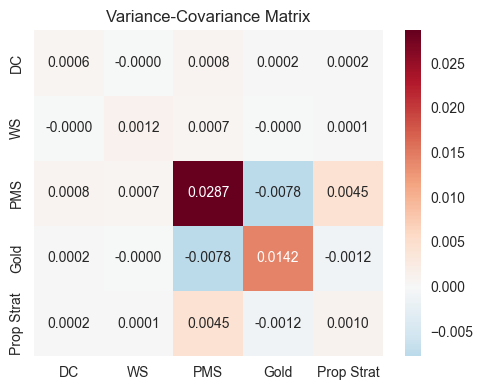

In [30]:
import libraries.help as help
importlib.reload(help)

covariance_matrix, variances = help.calculate_var_covar_pandas(data)
annual_covar_matrix = covariance_matrix * 12  # Annualize the covariance matrix
annual_vol_matrix = np.sqrt(annual_covar_matrix)

help.plot_covariance_matrix(annual_covar_matrix, instrument_names=data.columns)

In [31]:
num_assets = covariance_matrix.shape[0]
expected_returns = fund_data['Net Return'].values
covar_matrix = covariance_matrix.values  # Convert to numpy array

annual_covar_matrix = covar_matrix * 12  # Annualize covariance matrix

# Initializing the weights variable
weights = cp.Variable(num_assets)

# Calculate the portfolio volatility
portfolio_variance = cp.quad_form(weights, annual_covar_matrix)
portfolio_vol = cp.sqrt(portfolio_variance)
risk_tolerance = 0.06 # risk tolerance level
risk_tolerance_variance = risk_tolerance ** 2

# Define the objective function
objective = cp.Maximize(expected_returns @ weights)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0,
    portfolio_variance <= risk_tolerance_variance, # Risk tolerance constraint
]

# Formulate the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Check if the problem was solved successfully
print("Problem Status:", problem.status)
print("Optimal Value (Maximum Expected Return):", problem.value)
annual_expected_returns = expected_returns  # Annualize expected returns
# Extract the optimal weights
if problem.status == cp.OPTIMAL:
    optimal_weights = weights.value
    print("\nOptimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"Asset {i}: {weight:.4f} ({weight*100:.2f}%)")
    
    # Calculate portfolio metrics using annualized data
    portfolio_return = annual_expected_returns.T @ optimal_weights
    portfolio_risk = np.sqrt(optimal_weights.T @ annual_covar_matrix @ optimal_weights)
    
    print(f"\nAnnualized Portfolio Metrics:")
    print(f"Expected Return: {portfolio_return:.4f} ({portfolio_return*100:.2f}%)")
    print(f"Portfolio Risk (Volatility): {portfolio_risk:.4f} ({portfolio_risk*100:.2f}%)")
    
    # Calculate risk contributions using annualized covariance matrix
    marginal_risk_contribs = (annual_covar_matrix @ optimal_weights) / portfolio_risk
    risk_contributions = optimal_weights * marginal_risk_contribs
    
    print(f"\nRisk Contributions:")
    for i, risk_contrib in enumerate(risk_contributions):
        percentage = (risk_contrib / portfolio_risk) * 100
        print(f"Asset {i}: {risk_contrib:.4f} ({percentage:.2f}% of total risk)")
    
    # Verify constraints
    print(f"\nConstraint Verification:")
    print(f"Weights sum to 1: {np.sum(optimal_weights):.4f}")
    print(f"Portfolio risk <= tolerance: {portfolio_risk:.4f} <= {risk_tolerance}")
    print(f"All weights >= 0: {np.all(optimal_weights >= -1e-6)}")  # Small tolerance for numerical errors
    
else:
    print("Optimization failed!")
    print("Status:", problem.status)
    if problem.status == cp.INFEASIBLE:
        print("The problem is infeasible - constraints cannot be satisfied")
    elif problem.status == cp.UNBOUNDED:
        print("The problem is unbounded")


Problem Status: optimal
Optimal Value (Maximum Expected Return): 0.17708312522869132

Optimal Portfolio Weights:
Asset 0: 0.1864 (18.64%)
Asset 1: 0.0915 (9.15%)
Asset 2: 0.3443 (34.43%)
Asset 3: 0.3779 (37.79%)
Asset 4: 0.0000 (0.00%)

Annualized Portfolio Metrics:
Expected Return: 0.1771 (17.71%)
Portfolio Risk (Volatility): 0.0600 (6.00%)

Risk Contributions:
Asset 0: 0.0014 (2.40% of total risk)
Asset 1: 0.0005 (0.85% of total risk)
Asset 2: 0.0410 (68.35% of total risk)
Asset 3: 0.0170 (28.40% of total risk)
Asset 4: 0.0000 (0.00% of total risk)

Constraint Verification:
Weights sum to 1: 1.0000
Portfolio risk <= tolerance: 0.0600 <= 0.06
All weights >= 0: True


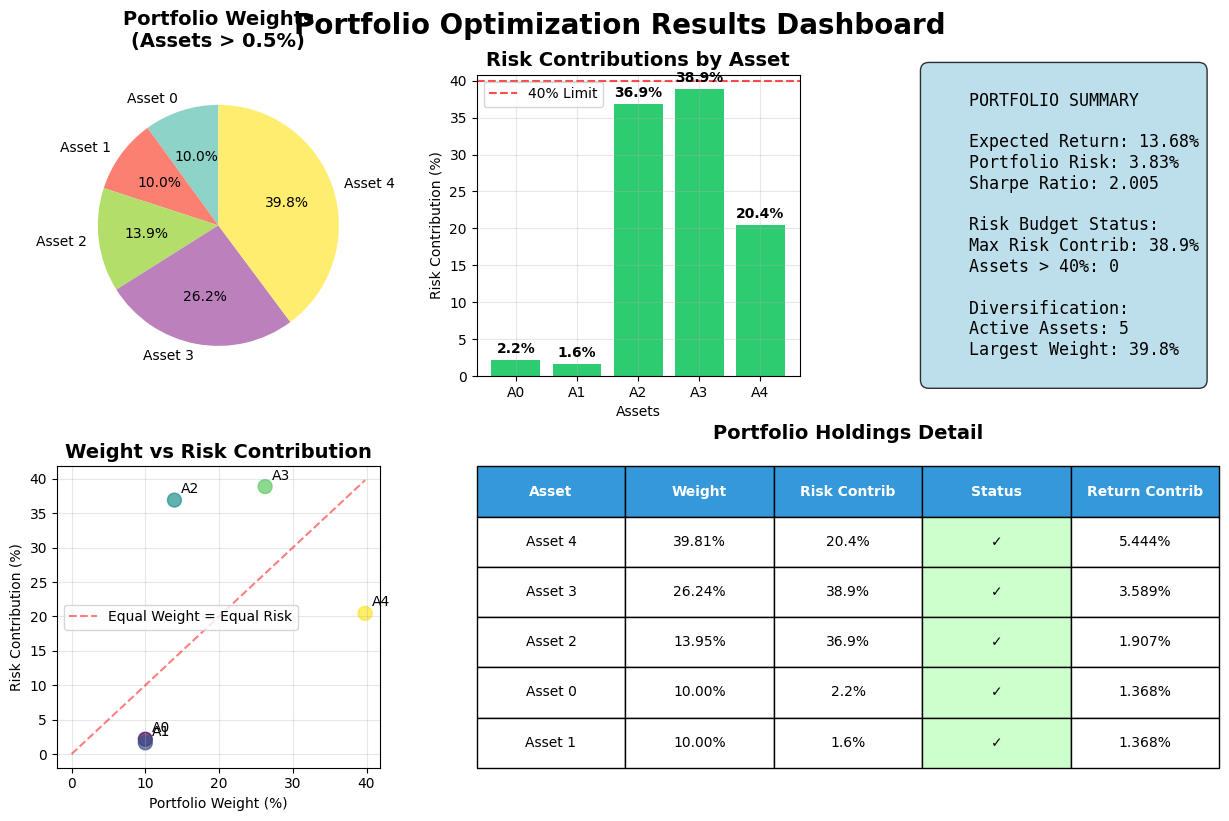

PORTFOLIO OPTIMIZATION SUMMARY
Expected Annual Return: 13.68%
Annual Risk (Volatility): 3.83%
Risk-Adjusted Return: 3.572
Number of Holdings: 5
Largest Position: 39.8%
Risk Budget Violations: 0 assets


In [34]:
import libraries.risk_budget as risk_budget
importlib.reload(risk_budget)
from libraries.risk_budget import visualize_portfolio_results, optimize_portfolio_with_risk_cap

results = optimize_portfolio_with_risk_cap(
    expected_returns=annual_expected_returns,
    covariance_matrix=annual_covar_matrix,
    risk_tolerance=0.10,  # Change this to change the risk tolerance of the portoflio
    max_risk_contrib=0.40,
    verbose=False
)

visualize_portfolio_results(results)
